In [1]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np

In [2]:
def get_historical_data(symbol,start_date,end_date):
    ''' Daily quotes from Google. Date format='yyyy-mm-dd' '''
    symbol = symbol.upper()
    start = datetime.date(int(start_date[0:4]), int(start_date[5:7]), int(start_date[8:10]))
    end = datetime.date(int(end_date[0:4]), int(end_date[5:7]), int(end_date[8:10]))
    url_string = "http://www.google.com/finance/historical?q={0}".format(symbol)
    url_string += "&startdate={0}&enddate={1}&num={0}&ei=KKltWZHCBNWPuQS9147YBw&output=csv".format(start.strftime('%b%d,%Y'), end.strftime('%b%d,%Y'),4000)
    stock_to_predict = yf.download("GOOGL", start, end)

#     col_names = ['Date','Open','High','Low','Close','Volume']
#     stocks = stock_to_predict[col_names] #filtered the columns
    stock_to_predict.head()
    df = pd.DataFrame(stock_to_predict)
    df = df.drop(["Adj Close"],axis=1)
    return df

In [3]:
data = get_historical_data("GOOGL", "2016-11-01", "2020-12-01")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2016-10-31,822.429993,822.630005,808.000000,809.900024,2242700
2016-11-01,810.869995,813.960022,798.260010,805.479980,2355900
2016-11-02,806.760010,806.760010,785.000000,788.419983,2350700
2016-11-03,784.500000,790.000000,778.630005,782.190002,2175200
2016-11-04,771.299988,788.479980,771.000000,781.099976,1970600
...,...,...,...,...,...
2020-11-23,1740.219971,1745.989990,1710.180054,1727.560059,1126500
2020-11-24,1727.500000,1766.479980,1720.729980,1763.900024,1399200
2020-11-25,1767.810059,1770.380005,1748.359985,1764.130005,980000


In [4]:
data.to_csv('google.csv',index = False)

array([[<AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>]], dtype=object)

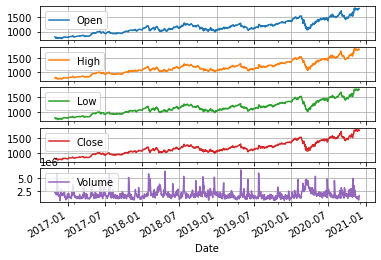

In [5]:
import matplotlib.pyplot as plt

data.loc[:, ['Open', "High", "Low", "Close", "Volume"]].plot(subplots=True, layout = (5,1), grid =True)

In [6]:
import math
import pandas as pd
import numpy as np
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression 

In [7]:
# y_t = np.array(data['Close'])
# X_t = data.copy()
# X_t = X_t.drop(['Close'],axis=1)
# X_t = np.array(X_t)
# from sklearn.preprocessing import MinMaxScaler
# normalizer = MinMaxScaler().fit(X_t,y=y_t)
# data = normalizer.transform(X_t,y=y_t) 
# data
# print("shape of Y :"+ str(y_t.shape))
# print("shape of X :"+ str(X_t.shape))
 
data.insert(0, 'Item', range(0, 0 + len(data)))
data.head()

,Item,Open,High,Low,Close,Volume
Date,,,,,,
2016-10-31,0,822.429993,822.630005,808.000000,809.900024,2242700
2016-11-01,1,810.869995,813.960022,798.260010,805.479980,2355900
2016-11-02,2,806.760010,806.760010,785.000000,788.419983,2350700
2016-11-03,3,784.500000,790.000000,778.630005,782.190002,2175200
2016-11-04,4,771.299988,788.479980,771.000000,781.099976,1970600


In [8]:
def train_test_split_linear_regression(stocks):
    """
        Split the data set into training and testing feature for Linear Regression Model
        :param stocks: whole data set containing ['Open','Close','Volume'] features
        :return: X_train : training sets of feature
        :return: X_test : test sets of feature
        :return: y_train: training sets of label
        :return: y_test: test sets of label
        :return: label_range: scaled range of label used in predicting price,
    """
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in stocks.iterrows():
        # print([np.array(row['Item'])])
        feature.append([(row['Item'])])
        label.append([(row['Close'])])

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .315
    split = int(math.floor(len(stocks['Item']) * split))

    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range

In [9]:
import math
def scale_range(x, input_range, target_range):
    """
    Rescale a numpy array from input to target range
    :param x: data to scale
    :param input_range: optional input range for data: default 0.0:1.0
    :param target_range: optional target range for data: default 0.0:1.0
    :return: rescaled array, incoming range [min,max]
    """

    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

In [10]:
X_train, X_test, y_train, y_test, label_range = train_test_split_linear_regression(data)

In [11]:
model = LinearRegression().fit(X_train,y_train)

In [12]:
predictions = model.predict(X_test)


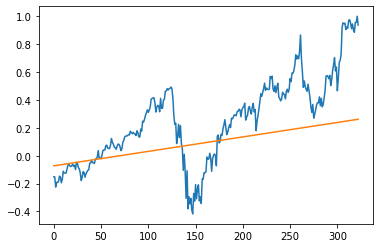

In [13]:
plt.plot(y_test)
plt.plot(predictions)
# fig,ax=plt.subplots()
# ax.plot(gapminder_us.year, gapminder_us.lifeExp, marker="o")
# ax.set_xlabel("days")
# ax.set_ylabel("lifeExp")
# ax.plot(gapminder_us.year, gapminder_us["gdpPercap"], marker="o")
# plt.show()

In [14]:
trainScore = mean_squared_error(X_train, y_train)
print(trainScore)
# print('Train Score: %.4f MSE (%.4f RMSE)' % (trainScore, math.sqrt(trainScore)))

testScore = mean_squared_error(predictions, y_test)
# print('Test Score: %.8f MSE (%.8f RMSE)' % (testScore, math.sqrt(testScore)))

0.06814080136109622


# Checkpoint 3 LSTM

In [15]:
pip install keras

You are using pip version 8.1.1, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import math
import pandas as pd
import numpy as np
from IPython.display import display

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import time #helper libraries

In [17]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential


def build_improved_model(input_dim, output_dim, return_sequences):
    """
    Builds an improved Long Short term memory model using keras.layers.recurrent.lstm
    :param input_dim: input dimension of model
    :param output_dim: ouput dimension of model
    :param return_sequences: return sequence for the model
    :return: a 3 layered LSTM model
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model


def build_basic_model(input_dim, output_dim, return_sequences):
    """
    Builds a basic lstm model 
    :param input_dim: input dimension of the model
    :param output_dim: output dimension of the model
    :param return_sequences: return sequence of the model
    :return: a basic lstm model with 3 layers.
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(LSTM(
        100,
        return_sequences=False))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [18]:
def train_test_split_lstm(stocks, prediction_time=1, test_data_size=450, unroll_length=50):
    """
        Split the data set into training and testing feature for Long Short Term Memory Model
        :param stocks: whole data set containing ['Open','Close','Volume'] features
        :param prediction_time: no of days
        :param test_data_size: size of test data to be used
        :param unroll_length: how long a window should be used for train test split
        :return: X_train : training sets of feature
        :return: X_test : test sets of feature
        :return: y_train: training sets of label
        :return: y_test: test sets of label
    """
    # training data
    test_data_cut = test_data_size + unroll_length + 1

    x_train = stocks[0:-prediction_time - test_data_cut].as_matrix()
    y_train = stocks[prediction_time:-test_data_cut]['Close'].as_matrix()

    # test data
    x_test = stocks[0 - test_data_cut:-prediction_time].as_matrix()
    y_test = stocks[prediction_time - test_data_cut:]['Close'].as_matrix()

    return x_train, x_test, y_train, y_test


In [40]:
y_t = np.array(data['Close'])
X_t = data.copy()
X_t = X_t.drop(['Close'],axis=1)
X_t = np.array(X_t)

from sklearn.preprocessing import MinMaxScaler
normalizer = MinMaxScaler().fit(X_t)
X_t = normalizer.transform(X_t) 
y_t = np.array(data['Close'])
y_t = y_t.reshape(-1,1)
normalizer = MinMaxScaler().fit(y_t)
y_t = normalizer.transform(y_t) 


print("shape of Y :"+ str(y_t.shape))
print("shape of X :"+ str(X_t.shape))

X_train,X_test, y_test, y_test = train_test_split(X_t,y_t,test_size=.20,random_state=42)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

shape of Y :(1028, 1)
shape of X :(1028, 5)
x_train (822, 5)
y_train (822, 1)
x_test (206, 5)
y_test (206, 1)


In [20]:
def unroll(data, sequence_length=24):
    """
    use different windows for testing and training to stop from leak of information in the data
    :param data: data set to be used for unrolling
    :param sequence_length: window length
    :return: data sets with different window.
    """
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

In [39]:
unroll_length = 50
X_train = unroll(X_train, unroll_length)
X_test = unroll(X_test, unroll_length)
# y_train = y_train[y_train.shape[0]:]
# y_test = y_test[y_test.shape[0]:]

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)

x_train (772, 50, 5)
y_train (822, 1)
x_test (156, 50, 5)
y_test (206, 1)


In [32]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential


def build_improved_model(input_dim, output_dim, return_sequences):
    """
    Builds an improved Long Short term memory model using keras.layers.recurrent.lstm
    :param input_dim: input dimension of model
    :param output_dim: ouput dimension of model
    :param return_sequences: return sequence for the model
    :return: a 3 layered LSTM model
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(Dropout(0.2))

    model.add(LSTM(
        128,
        return_sequences=False))

    model.add(Dropout(0.2))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model


def build_basic_model(input_dim, output_dim, return_sequences):
    """
    Builds a basic lstm model 
    :param input_dim: input dimension of the model
    :param output_dim: output dimension of the model
    :param return_sequences: return sequence of the model
    :return: a basic lstm model with 3 layers.
    """
    model = Sequential()
    model.add(LSTM(
        input_shape=(None, input_dim),
        units=output_dim,
        return_sequences=return_sequences))

    model.add(LSTM(
        100,
        return_sequences=False))

    model.add(Dense(
        units=1))
    model.add(Activation('linear'))

    return model

In [33]:
# build basic lstm model
model = build_basic_model(input_dim = X_train.shape[-1],output_dim = unroll_length, return_sequences=True)

# Compile the model
start = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
print('compilation time : ', time.time() - start)

compilation time :  0.004967927932739258


In [34]:
model.fit(
    X_train,
    y_train,
    epochs=1,
    validation_split=0.05)

ValueError: Data cardinality is ambiguous:
  x sizes: 733
  y sizes: 0
Make sure all arrays contain the same number of samples.